This notebook will be used to conduct error analysis on our model using the same partitions of training and test data that we used in Lab 4 to generate the model. We will generate graphs of learning rate in training and test, then look at accuracy for each letter, then generate a confusion matrix.

In [0]:
# Import required libraries

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import time
plt.style.use('seaborn')

from skimage.color import rgb2gray
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Using PyTorch methods on training data
import torch
import torchvision as tv
from torchvision import transforms as tv_tf

# Import neural net
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# # # Load files to Colab
# from google.colab import files
# uploaded = files.upload()

KeyboardInterrupt: ignored

In [0]:
# Define convolutional neural net class for grayscale images

class ConvNetGray(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers - try reducing number of layers in linear layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        # self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
        # Need to pass some garbage data to determine shape of input to linear layer
        x = torch.randn(100,100).view(-1,1,100,100)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 9)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

In [0]:
# Preprocessing function:
# Takes in data and labels, returns transformed data and labels
# Transformations: Data will be converted to grayscale, labels will be encoded to be integers

def PreProcess(data, labels):
    # Convert training and test data to grayscale
    X_gray = rgb2gray(data)
    
    # Encode class labels
    LE = LabelEncoder()
    y_flat = labels.ravel()
    y_nums = LE.fit_transform(y_flat)
        
    # Convert to tensors
    X_tn = torch.Tensor(X_gray)
    y_tn = torch.Tensor(y_nums).type(torch.LongTensor)

    return X_tn, y_tn

In [0]:
# Function to train a model
# Parameters passed are an un-trained CNN model, Batch Size, Epochs, Loss Funtion, and Initial Learning Rate
# We will also pass in the data with which we want to train the model - used for comparing the training sets

def TrainModel(CNN, BatchSize, Epochs, Loss_Function, Init_LR, X, y):
    gpu.empty_cache()
    
    print("Training above CNN with Batches of", BatchSize, "over", Epochs, "epochs...")

    BATCH_SIZE = BatchSize
    EPOCHS = Epochs

    opt = optim.Adam(CNN.parameters(), lr=Init_LR)
    loss_function = Loss_Function

    for epoch in range(EPOCHS):
        for i in range(0, len(X), BATCH_SIZE): 

            batch_X = X[i:i+BATCH_SIZE].view(-1, 1, 100, 100)
            batch_y = y[i:i+BATCH_SIZE]

            CNN.zero_grad()
            outputs = CNN(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            opt.step()

        opt = optim.Adam(CNN.parameters(), lr=New_LR)


In [0]:
# Model evaluation function: Loads a pre-trained model and evaluates it using pre-processed test data w/ labels, outputs accuracy and predicted labels

def EvaluateModel(model, X, y):

    correct = 0
    total = 0
    y_pred_nums = np.zeros(len(y))
    with torch.no_grad():
        for i in range(len(X)):
            output = model(X[i].view(-1, 1, 100, 100))
            y_true = y[i]
            y_pred_nums[i] = torch.argmax(output)
            if y_true == y_pred_nums[i]:
                correct += 1
            total += 1
    
    return round(correct/total, 3), y_pred_nums

In [0]:
# Post-processing function to convert the predicted labels from numbers to letters

def PostProcess(labels, nums):
    
    # First we need to re-establish the initial transformation of labels to numbers
    LE = LabelEncoder()
    y_flat = labels.ravel()
    y_nums = LE.fit_transform(y_flat)
    
    # Now we need to convert the predicted numbers to letters
    # Convert nums from float to int
    nums = nums.astype(int)
        
    # Use inverse_transform method to revert encoding
    letters = LE.inverse_transform(nums)
    
    return letters

In [0]:
# TrainFunction will take in the training data, pre-process it, generate an un-trained model, train that model, and return it
def TrainFunction(X, y):

    # First we pre-process the training data (it was loaded in the cell with the imports)
    X_train, y_train = PreProcess(X, y)

    # Next we instantiate an un-trained model and loss function
    untrained_model = ConvNetGray()
    CE_Loss = nn.CrossEntropyLoss()

    # Train the un-trained model using the same parameters as we did for the model we saved
    TrainFunction(CNN=untrained_model, BatchSize=128, Epochs=1000, Loss_Function=CE_Loss, Init_LR=0.001, X=X_train, y=y_train)
    # untrained_model should now be trained so lets rename it
    trained_model = untrained_model
    
    return trained_model

In [0]:
# TestFunction will take in a dataset, pre-process it, then load a pre-trained model and evaluate it
# Returns accuracy and predicted labels
def TestFunction(X, y):

    # First we pre-process the test data 
    X_test, y_test = PreProcess(X, y)

    # Next we load in our pre-trained model
    pretrained_model = torch.load('CNN_23.pt', map_location=torch.device('cpu'))

    # And now we evaluate a pre-trained model using the transformed test data
    accuracy, predicted_nums = EvaluateModel(pretrained_model, X_test, y_test)
    
    # Finally do post-processing to get labels as letters
    predicted_labels = PostProcess(labels=y, nums=predicted_nums)

    return accuracy, predicted_labels

In [65]:
# Load in required datasets
train_data = np.load('provided_train_data.npy')
train_labels = np.load('provided_train_labels.npy')
test_data = np.load('provided_test_data.npy')
test_labels = np.load('provided_test_labels.npy')

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(1475, 100, 100, 3) (1475, 1) (369, 100, 100, 3) (369, 1)


In [71]:
# Verifying we get the same results as before
accuracy, predicted_labels = TestFunction(test_data, test_labels)
print(accuracy)

0.897


In [72]:
# Determine classifier accuracy for each letter

A_correct = B_correct = C_correct = D_correct = E_correct = F_correct = G_correct = H_correct = I_correct = 0
A_total = B_total = C_total = D_total = E_total = F_total = G_total = H_total = I_total = 0

for i in range(len(predicted_labels)):
  if (test_labels[i] == 'A'):
    if (predicted_labels[i] == test_labels[i]):
      A_correct+= 1
    A_total+= 1
  elif (test_labels[i] == 'B'):
    if (predicted_labels[i] == test_labels[i]):
      B_correct+= 1
    B_total+= 1
  elif (test_labels[i] == 'C'):
    if (predicted_labels[i] == test_labels[i]):
      C_correct+= 1
    C_total+= 1
  elif (test_labels[i] == 'D'):
    if (predicted_labels[i] == test_labels[i]):
      D_correct+= 1
    D_total+= 1
  elif (test_labels[i] == 'E'):
    if (predicted_labels[i] == test_labels[i]):
      E_correct+= 1
    E_total+= 1
  elif (test_labels[i] == 'F'):
    if (predicted_labels[i] == test_labels[i]):
      F_correct+= 1
    F_total+= 1
  elif (test_labels[i] == 'G'):
    if (predicted_labels[i] == test_labels[i]):
      G_correct+= 1
    G_total+= 1
  elif (test_labels[i] == 'H'):
    if (predicted_labels[i] == test_labels[i]):
      H_correct+= 1
    H_total+= 1
  elif (test_labels[i] == 'I'):
    if (predicted_labels[i] == test_labels[i]):
      I_correct+= 1
    I_total+= 1

A_acc = round(A_correct/A_total, 3)*100
B_acc = round(B_correct/B_total, 3)*100
C_acc = round(C_correct/C_total, 3)*100
D_acc = round(D_correct/D_total, 3)*100
E_acc = round(E_correct/E_total, 3)*100
F_acc = round(F_correct/F_total, 3)*100
G_acc = round(G_correct/G_total, 3)*100
H_acc = round(H_correct/H_total, 3)*100
I_acc = round(I_correct/I_total, 3)*100

# Had to do this because round wasn't working properly for H
H_acc = round(H_acc, 3)

print("Accuracy per Letter: ")
print("A: "+ str(A_acc) + "%")
print("B: "+ str(B_acc) + "%")
print("C: "+ str(C_acc) + "%")
print("D: "+ str(D_acc) + "%")
print("E: "+ str(E_acc) + "%")
print("F: "+ str(F_acc) + "%")
print("G: "+ str(G_acc) + "%")
print("H: "+ str(H_acc) + "%")
print("I: "+ str(I_acc) + "%")


Accuracy per Letter: 
A: 89.1%
B: 90.2%
C: 92.9%
D: 90.0%
E: 90.9%
F: 92.7%
G: 81.8%
H: 92.1%
I: 88.2%


Confusion Matrix:


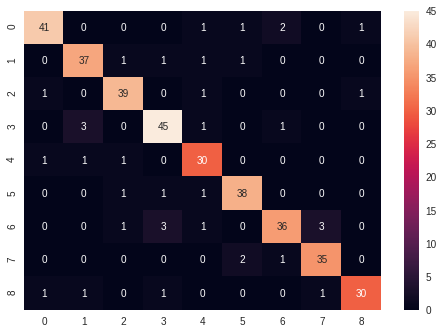

In [73]:
# Print confusion matrix:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
hm = sb.heatmap(C, annot=True)
bottom, top = hm.get_ylim()

# # Save this to a file
# figure = hm.get_figure()
# figure.savefig('ConfusionMatrix.png')

### Generate graphs of learning rate for training and validation

Plotting accuracy (y-axis) against number of epochs.

Since we need to train a new model, we will first init cuda. Then we need to modify TrainModel function and EvaluateModel functions to do this. Will also need to pre-process train and test sets beforehand.

**The following code has been commented out after being run once. I saved the data to plot the learning rates and that is shown further below**

In [0]:
# # Init cuda for GPU usage
# import torch.cuda as gpu
# # Check if available
# print("Available GPU:", gpu.is_available())
# # Get Id and name of default device
# print(gpu.current_device())
# print(torch.cuda.get_device_name(0)) # '0' is the id of your GPU
# # Check memory stats
# print("Total bytes:", gpu.get_device_properties(0).total_memory)
# print("Bytes allocated:", gpu.memory_allocated())
# print("Bytes cached:", gpu.memory_cached())

In [0]:
# # Generate transformed training and test data:

# X_train_tn, y_train_tn = PreProcess(train_data, train_labels)
# X_test_tn, y_test_tn = PreProcess(test_data, test_labels)

# X_train_tn = X_train_tn.cuda()
# y_train_tn = y_train_tn.cuda()
# X_test_tn = X_test_tn.cuda()
# y_test_tn = y_test_tn.cuda()

# print(X_train_tn.shape, y_train_tn.shape, X_test_tn.shape, y_test_tn.shape)

In [0]:
# # Modify TrainModel function:
# def GetLearningCurves(CNN, BatchSize, Epochs, Init_LR, X, y):
#     gpu.empty_cache()
    
#     print("Training above CNN with Batches of", BatchSize, "over", Epochs, "epochs...")
#     BATCH_SIZE = BatchSize
#     EPOCHS = Epochs

#     # New stuff here:
#     # Values for x-axis are the number of epochs
#     epochs_arr = np.arange(Epochs)
#     # Values for y-axis will be the accuracy in each epoch
#     acc_per_epoch_train = np.zeros(Epochs)
#     acc_per_epoch_test = np.zeros(Epochs)

#     opt = optim.Adam(CNN.parameters(), lr=Init_LR)
#     loss_function = nn.CrossEntropyLoss()

#     for epoch in range(EPOCHS):
#         for i in range(0, len(X), BATCH_SIZE): 
#             batch_X = X[i:i+BATCH_SIZE].view(-1, 1, 100, 100).cuda()
#             batch_y = y[i:i+BATCH_SIZE].cuda()

#             CNN.zero_grad()
#             outputs = CNN(batch_X).cuda()
#             loss = loss_function(outputs, batch_y).cuda()
#             loss.backward()
#             opt.step()   # Does the update

#         # Determine accuracy in this epoch using modified evaluation function:
#         acc_per_epoch_train[epoch] = ScoreModel(CNN, X_train_tn, y_train_tn)
#         acc_per_epoch_test[epoch] = ScoreModel(CNN, X_test_tn, y_test_tn)

#         gpu.empty_cache()

#     return epochs_arr, acc_per_epoch_train, acc_per_epoch_test

In [0]:
# # Modified evaluation function
# def ScoreModel(model, X, y):
#     correct = 0
#     total = 0
#     y_pred_nums = np.zeros(len(y))
#     with torch.no_grad():
#         for i in range(len(X)):
#             output = model(X[i].view(-1, 1, 100, 100))
#             y_true = y[i]
#             y_pred_nums[i] = torch.argmax(output)# + 1 # This +1 is to match the output encoding of the labels
#             if y_true == y_pred_nums[i]:
#                 correct += 1
#             total += 1
    
#     return round(correct/total, 3)

In [0]:
# # Instantiate un-trained model to train and get data for learning rate plots from
# newModel = ConvNetGray().cuda()
# # Train model using modified training function and get learning rate data
# epochs_arr, train_acc, test_acc =  GetLearningCurves(CNN=newModel, BatchSize=128, Epochs=1000,
#                                                      Init_LR = 0.001, X=X_train_tn, y=y_train_tn)


### Plotting Learning Rates:

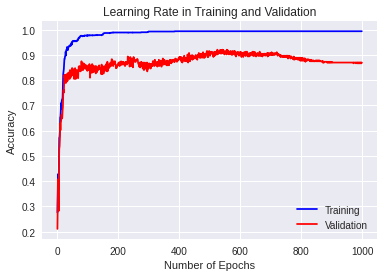

In [43]:
# Load values for plotting learning rate
epochs_arr0 = np.arange(1000)
train_acc0 = np.load('LearningRateTrainAcc.npy')
test_acc0 = np.load('LearningRateTestAcc.npy')

# Plot learning rate graphs
plt.plot(epochs_arr0, train_acc0, 'b', label='Training')
plt.plot(epochs_arr0, test_acc0, 'r', label='Validation')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title("Learning Rate in Training and Validation")
plt.savefig('LearningRate.png')